<a href="https://colab.research.google.com/github/Eleemon98/JDF/blob/main/0411_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Tensorflow Lite 모델 로드
interpreter = tf.lite.Interpreter(model_path='1.tflite')
interpreter.allocate_tensors()

In [2]:
# 입출력 정보 저장
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [3]:
# 이미지로드 및 전처리
def load_preprocess_image(image_path):
  img = tf.io.read_file(image_path) # 파일 위치에서 파일 가져오기
  img = tf.image.decode_png(img, channels=3) # 이미지를 numpy의 어레이로 변환
  img = tf.image.resize(img, [257,257]) # input shape에 맞게 이미지 설정
  img = img / 255 # 이미지 스케일링
  img = img[tf.newaxis, ...] # shape 정보를 [1,257,257,3]으로 변경
  return img

In [5]:
# 이미지 Segmentation 함수
def segment_image(image_path):
  # 이미지 로드 및 전처리
  img = load_preprocess_image(image_path)

  # 실제 모델에 이미지 입력
  interpreter.set_tensor(input_details[0]['index'], img)
  interpreter.invoke()

  # 이미지 segmentation 출력
  seg_map = interpreter.get_tensor(output_details[0]['index'])
  seg_map = np.squeeze(seg_map) # 크기가 1인 axis 제거

  return img[0], seg_map # img[0]은 segmentation 전 img / seg_map은 segmentation후의 이미지

In [12]:
# 이미지 가져오기
image_path = "strolling.jpg"

# 이미지 Segmentation 실행
original_img, seg_map = segment_image(image_path)

# 각 픽셀에 대해 가장 높은 확률을 가진 클래스의 인덱스를 찾기
predicted_class_indices = tf.argmax(seg_map, axis=-1)

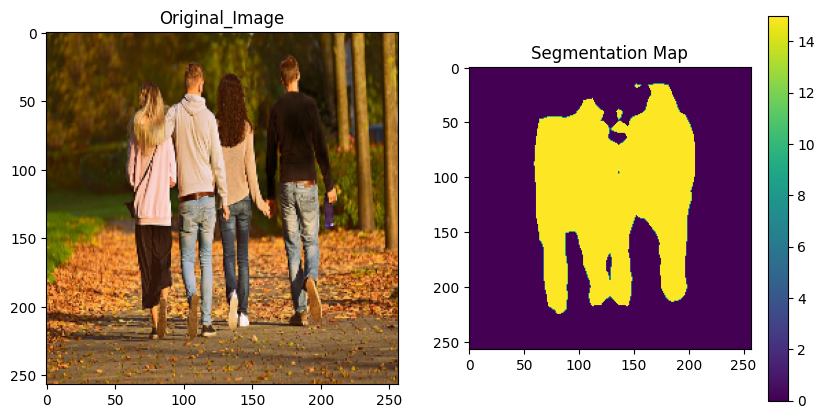

In [13]:
# 시각화 하기
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(original_img)
plt.title('Original_Image')
plt.subplot(1,2,2)
plt.imshow(predicted_class_indices)
plt.colorbar()
plt.title('Segmentation Map')
plt.show()

In [2]:
!python -m pip install pyyaml==5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
!git clone 'https://github.com/facebookresearch/detectron2'

Cloning into 'detectron2'...
remote: Enumerating objects: 15528, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 15528 (delta 82), reused 185 (delta 41), pack-reused 15275
Receiving objects: 100% (15528/15528), 6.40 MiB | 12.34 MiB/s, done.
Resolving deltas: 100% (11193/11193), done.


In [4]:
import sys, os, distutils.core
dist = distutils.core.run_setup('./detectron2/setup.py')

In [7]:
# node.js에서 처럼 npm install과 같은 코드
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=e9f3270a356535b0d6bb6dcd9dfd66d02c8093e1249c5391896e6a4f5e0ce525
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=f8c9b7fda3211d59fa51820344d52d3d9d65da17d3378ef40457a9ff39aa1e4d
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a1

In [8]:
# 환경 변수 설정
sys.path.insert(0, os.path.abspath('./detectron2'))

In [9]:
# 로그 설정 초기화
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [11]:
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

In [12]:
from detectron2 import model_zoo # 사전학습된 모델
from detectron2.engine import DefaultPredictor # 설정된 모델의 예측실행 모듈
from detectron2.config import get_cfg # 모델 설정
from detectron2.utils.visualizer import Visualizer # 예측 결과 시각화
from detectron2.data import MetadataCatalog, DatasetCatalog # 메타 데이터랑 데이터셋 관리

In [13]:
cfg = get_cfg() # 모델 객체 생성
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

In [14]:
# 모델이 객체를 탐지하기 위한 임계값 설정
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

In [15]:
# 사전 학습된 모델의 가중치를 설정
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml')

In [16]:
# 예측결과 모듈 생성
predictor = DefaultPredictor(cfg)

[04/11 06:51:14 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:00, 191MB/s]                           


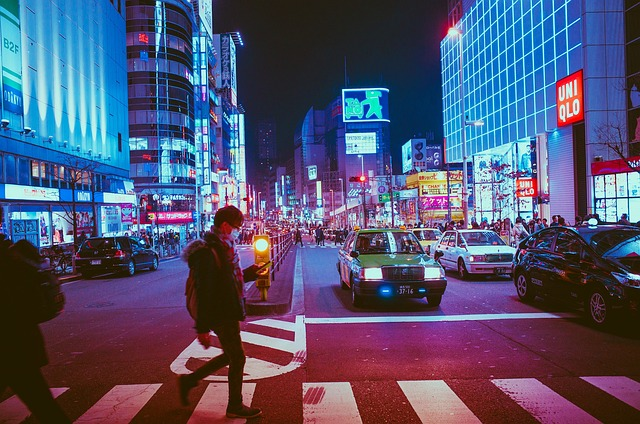

In [19]:
# 이미지 가져오기
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
# im = cv2.imread("./input.jpg")
im = cv2.imread("./japan.jpg")
cv2_imshow(im)

In [20]:
outputs = predictor(im)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [21]:
# 내 이미지에서 찾은 object들의 각 class 객체
print(outputs['instances'].pred_classes)
# 각 class 객체에 박스 위치와 크기
print(outputs['instances'].pred_boxes)

tensor([2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
Boxes(tensor([[508.1739, 224.5304, 639.0153, 328.2449],
        [181.3468, 205.6362, 259.2600, 416.4044],
        [336.4282, 226.8538, 446.7920, 309.5930],
        [434.4018, 228.1769, 513.3978, 278.7875],
        [ 74.0253, 234.1859, 158.1189, 279.1685],
        [410.8442, 227.4931, 442.3614, 256.7408],
        [315.5927, 224.7926, 324.6769, 246.8161],
        [  1.5748, 235.8097,  67.7749, 422.8525],
        [294.7460, 227.4833, 303.6778, 247.6147],
        [550.1309, 215.2432, 559.2953, 226.1916],
        [173.8829, 232.6582, 180.2223, 251.5017],
        [618.5056, 213.3873, 629.1210, 223.2648],
        [513.9567, 217.0414, 529.8519, 237.9448],
        [470.8738, 219.3633, 479.5928, 228.9226],
        [541.8278, 217.8098, 548.6215, 227.9974],
        [556.8698, 215.2199, 565.4616, 225.7625],
        [479.6028, 218.9590, 487.8109, 229.1225],
        [533.8394, 218.7040, 543.4327, 232.4525],
 

In [1]:
# Visualizer 시각화 툴 사용
# im[:,:,::-1] => BGR에서 RGB로 변환
# Output에서 출력된 정보를 각각 메타데이터와 매칭하여 실제 이름을 출력
# 스케일 키우기
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)

NameError: name 'Visualizer' is not defined

In [2]:
# 시각화를 할 때 결과값을 cpu에 보내는 코드
out = v.draw_instance_predictions(outputs['instances'].to("cpu"))
cv2_imshow(out.get_image([:,:,::-1]))

SyntaxError: invalid syntax (<ipython-input-2-d01d00674935>, line 3)